### Fraud Detection
* In this notebook I use a publickly available dataset `'FraudDetection.xlsx'`to create a fraud detection model.

* I used Python in the first phase to prepare the data and split it into **training** and **test** datasets.

* Then I use [Gretl](https://gretl.sourceforge.net/) to create the model and extract the required **predictions** for further processing using Python.

* The **Cumulative Accuary Profile (CAP)** curve was produced using excel.

* The accuary of the model on both training and test dataset is above **90%** with no signs of overfitting!!!

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from sklearn import metrics, linear_model, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('FraudDetection.xlsx', na_values = 'NA')
print(df.shape)
df.head()

(16281, 15)


,Transaction_ID,Card Tenure_months,WebsiteRegion,Trans_value,Seller_Category,Items_transaction,Shipping_Address,Purchase_Category,Othercard_owner,Seller_way,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Countryissuedcard,Fraud_Detected
0,1,25,US,256.41,Store + online,10,US,online services,Dependent,Yes,0,0,40,United-States,No
1,2,38,US,409.54,Online only,8,International,Accessories,Husband,Yes,0,0,50,United-States,No
2,3,28,EU,293.09,Online only,5,International,Electornics,Husband,Yes,0,0,40,United-States,Yes
3,4,44,US,444.07,Online only,7,International,online services,Husband,Yes,7688,0,40,United-States,Yes
4,5,18,EU,183.11,Online only,7,US,Food,Dependent,No,0,0,30,United-States,No


In [3]:
df_new = df.copy()
df_new.rename(columns = {'Transaction_ID': 'ID', 'Fraud_Detected': 'target', 'Card Tenure_months': 'Tenure'}, inplace = True)
df_new.rename(columns = {'Trans_value': 'TransValue', 'Seller_Category': 'SellerCategory'}, inplace = True)
df_new.rename(columns = {'Items_transaction': 'ItemsTransaction', 'Shipping_Address': 'ShippingAddress'}, inplace = True)
df_new.rename(columns = {'Purchase_Category': 'PurchaseCategory', 'Countryissuedcard': 'CountryIssuedCard'}, inplace = True)
df_new.rename(columns = {'Othercard_owner': 'OtherCardOwner', 'LastMonthsTrans_Freq': 'LastMonthsTransFreq'}, inplace = True)
df_new.rename(columns = {'Lastflagedvalue': 'LastFlagedValue', 'Seller_way': 'SellerWay'}, inplace = True)
df_new.head()

,ID,Tenure,WebsiteRegion,TransValue,SellerCategory,ItemsTransaction,ShippingAddress,PurchaseCategory,OtherCardOwner,SellerWay,LastTransaction,LastFlagedValue,LastMonthsTransFreq,CountryIssuedCard,target
0,1,25,US,256.41,Store + online,10,US,online services,Dependent,Yes,0,0,40,United-States,No
1,2,38,US,409.54,Online only,8,International,Accessories,Husband,Yes,0,0,50,United-States,No
2,3,28,EU,293.09,Online only,5,International,Electornics,Husband,Yes,0,0,40,United-States,Yes
3,4,44,US,444.07,Online only,7,International,online services,Husband,Yes,7688,0,40,United-States,Yes
4,5,18,EU,183.11,Online only,7,US,Food,Dependent,No,0,0,30,United-States,No


In [4]:
df_new['target'] = (df_new.target == 'Yes') + 0 
df_new['SellerWay'] = (df_new.SellerWay == 'Yes') + 0 
df_new.head()

,ID,Tenure,WebsiteRegion,TransValue,SellerCategory,ItemsTransaction,ShippingAddress,PurchaseCategory,OtherCardOwner,SellerWay,LastTransaction,LastFlagedValue,LastMonthsTransFreq,CountryIssuedCard,target
0,1,25,US,256.41,Store + online,10,US,online services,Dependent,1,0,0,40,United-States,0
1,2,38,US,409.54,Online only,8,International,Accessories,Husband,1,0,0,50,United-States,0
2,3,28,EU,293.09,Online only,5,International,Electornics,Husband,1,0,0,40,United-States,1
3,4,44,US,444.07,Online only,7,International,online services,Husband,1,7688,0,40,United-States,1
4,5,18,EU,183.11,Online only,7,US,Food,Dependent,0,0,0,30,United-States,0


In [5]:
df_new.to_csv('fraud_detection.csv')

#### Split the data into training and testing data

In [6]:
fraud_train = df_new.sample(frac = 0.75, random_state = 45)
print(fraud_train.shape)

(12211, 15)


In [7]:
fraud_train.to_csv('fraud_train.csv')

In [8]:
fraud_test = df_new.drop(fraud_train.index)
print(fraud_test.shape)

(4070, 15)


In [9]:
fraud_test.to_csv('fraud_test.csv')

In [11]:
test_features = fraud_test.drop('target', axis = 1)
test_target = fraud_test.target

In [12]:
test_features.to_csv('test_features.csv')
test_target.to_csv('test_target.csv')

### Using Gretl
I use [Gretl](https://gretl.sourceforge.net/) to create the model and extract the required **predictions** for further processing...

#### Gretl Output

In [55]:
output = pd.read_clipboard()
output

,Coefficient,Std. Error,z,p-value,rating
Features,,,,,
const,−2.42168,0.393774,−6.150,<0.0001,***
TransValue,0.00234423,0.000248,9.452,<0.0001,***
ItemsTransaction,−0.299280,0.014433,−20.74,<0.0001,***
SellerWay,0.3969,0.122088,3.251,0.0012,***
LastTransaction,0.000348194,0.000018,19.59,<0.0001,***
LastFlagedValue,0.000714609,0.000061,11.68,<0.0001,***
LastMonthsTransFreq,0.0276648,0.002523,10.97,<0.0001,***
Web_EU,−0.251717,0.096554,−2.607,0.0091,***
Web_UC,−0.744908,0.099262,−7.504,<0.0001,***


Above are the selected **best predictors**. The **`pvalues << 0.05`** indicating that these predictors are strongly **correlated with the dependent variable, `target`**.

### Receiver Operating Characteristics(ROC) and Area Under Curve(AUC)
The area under the ROC is widely used to validate classification models. The **closer AUC is to 1 or 100% the better the model**.

**We use the ground truth `y_train`and the predicted probabilities `y_pred` to compute the `false positive rate (FPR)` and `true positive rate (TPR)` which are then used to calculate the `AUC` and to derived the `ROC` curve.**

**The prediction probabilities `y_pred` were produced by Gretl.**

In [27]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [28]:
ytrain_ypred = pd.read_csv('ytrain_y_pred.csv')
ytrain_ypred.head()

,y_train,y_pred
0,1,0.914936
1,0,0.077563
2,0,0.064761
3,1,0.523124
4,0,0.004375


In [29]:
y_train = ytrain_ypred.y_train
y_pred = ytrain_ypred.y_pred

false_pr, true_pr, thresholds = roc_curve(y_train, y_pred)     # False Positive Rate, True Positive Rate
auc_train = auc(false_pr, true_pr)                             # Area Under Curve
print(auc_train)

0.9043392476285955


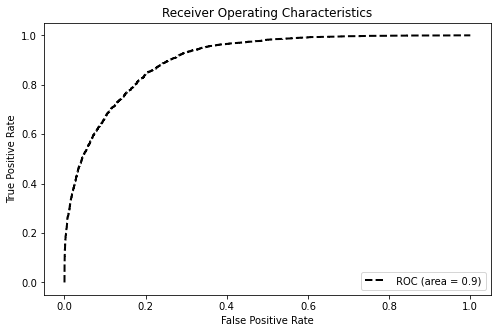

In [30]:
plt.figure(figsize = (8, 5))
plt.plot(false_pr, true_pr, 'k--', label = f' ROC (area = {round(auc_train, 2)})', lw = 2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc = 'lower right')
plt.show()

* The **Area Under Curve (AUC)** should higher than **0.5**, the closer it is to **1** the better.
* An AUC of **0.5** is the same as *random picking*
* A **too high AUC** might be a sign of **overfitting**

#### KS distance 
This is the **difference between `TPR` and `FPR`**. A KS distance of above **40%** is considered good!

In [31]:
kss = np.abs(true_pr - false_pr)             
ks = kss.max()                      # max distance
print(f'KS of the model is: {ks}')

KS of the model is: 0.6461485433894599


### Cummulative Accuracy Profile (CAP) - Training

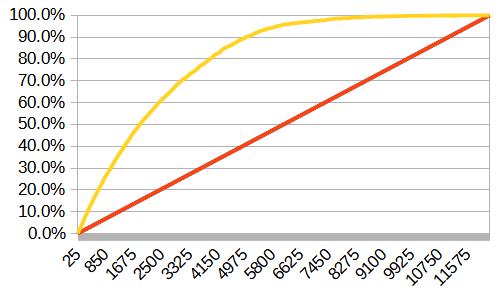            

### Ad Hoc Interpretation of the CAP curve

* Draw a vertical line at **50%** mark from the x-axis till it crosses the model curve.
* At the point, where this vertical line cuts the trained model curve is the **accuracy** read from the y-axis.

The following **rule of thumb** is used to interprete the accuracy:

1. Less than **60%** ==> Rubbish Model
2. Between **60% — 70%** ==> Poor Model
3. Between **70% — 80%** ==> Good Model
4. Between **80% — 90%** ==> Very Good Model
5. Above **90%** ==> Too Good to be True but possible

For this model the **50%** is around **6100** samples. This gives an accuracy of about **93%**!! It might be that the model is **overfitting**. However, the evaluation using test data suggest otherwise! **See below!**

### Evaluating the model using test dataset

In [37]:
ytest_ypred = pd.read_excel('test_prediction_probabilities.xlsx', usecols = ['Fraud', 'P_Hat_test'])
ytest_ypred.head()

,Fraud,P_Hat_test
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


In [38]:
ytest_ypred.rename(columns = {'Fraud': 'y_test', 'P_Hat_test': 'y_pred_test'}, inplace = True)

ytest_ypred.head()

,y_test,y_pred_test
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


In [39]:
y_test = ytest_ypred.y_test
y_pred_test = ytest_ypred.y_pred_test

false_pr, true_pr, thresholds = roc_curve(y_test, y_pred_test)     # fpr = False Positive Rate, tpr = True Positive Rate
auc_test = auc(false_pr, true_pr)                                     # Area Under Curve
print(auc_test)

0.8945468171823797


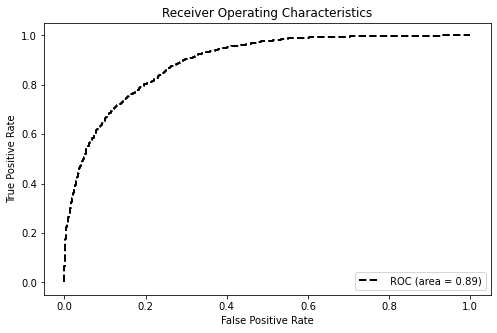

In [40]:
plt.figure(figsize = (8, 5))
plt.plot(false_pr, true_pr, 'k--', label = f' ROC (area = {round(auc_test, 2)})', lw = 2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc = 'lower right')
plt.show()

In [41]:
kss = np.abs(true_pr - false_pr)             
ks = kss.max()                      # max distance
print(f'KS of the model(test) is: {ks}')

KS of the model(test) is: 0.6125684680430328


### Cummulative Accuracy Profile (CAP) - Testing

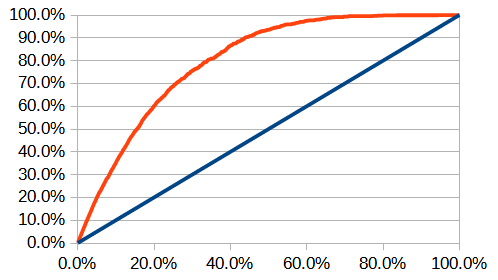

The accuracy of the model using the test data is also around **93%**!! This suggests that the model is **really good!!**

**This means that if 50% of the data is analysed without the model only 50% of the fraudulent cases would be discovered. But using the model, we would be able to identify about 90% of the fraudulent cases in the same amount of data!!** 

### Intepreting the logistic regression coefficient using Odds Ratio

In [43]:
coefs = pd.read_clipboard()

,Features,Coefficient,Calculated_odds_ratio
0,TransValue,0.002344,1.00235
1,ItemsTransaction,-0.299280,0.74135
2,SellerWay,0.396900,1.48721
3,LastTransaction,0.000348,1.00035
4,LastFlagedValue,0.000715,1.00071
5,LastMonthsTransFreq,0.027665,1.02805
6,Web_EU,-0.251717,0.77746
7,Web_UC,-0.744908,0.47478
8,Online_Only,0.281471,1.32508
9,Shipping_Int,2.088970,8.07659


In [53]:
coefs.style.background_gradient(subset = ['Calculated_odds_ratio'], cmap = 'Reds') 

,Features,Coefficient,Calculated_odds_ratio
0,TransValue,0.002344,1.002350
1,ItemsTransaction,-0.299280,0.741350
2,SellerWay,0.396900,1.487210
3,LastTransaction,0.000348,1.000350
4,LastFlagedValue,0.000715,1.000710
5,LastMonthsTransFreq,0.027665,1.028050
6,Web_EU,-0.251717,0.777460
7,Web_UC,-0.744908,0.474780
8,Online_Only,0.281471,1.325080
9,Shipping_Int,2.088970,8.076590


**It be seen that the most significant feature is `Shipping International`and Shipping to international destinations is linked to `Shopping Online`**. This is where most of the **fraud** take place!! 

All other features remaining constant, a switch in **`SellerWay`** from **NO** to  **YES** would increase the rate of fraud by almost **50%**! 